In [1]:
%%html
<style>
table {float:left}
</style>

# <font color="red">Session 4 Hard Challenge:</font><br>Quantum Reservoir Computing

<table>
    <tr><td><strong>Aim:</strong></td>
        <td>To create and use a quantum reservoir computing model in <strong>PennyLane</strong>.<br>
            Compare this quantum reservoir with the equivalent classical reservoir.</td></tr>
    <tr><td><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td><strong>Release:</strong></td>
        <td>April 2025</td></tr>
    <tr><td><strong>Datasets:</strong></td>
        <td>We will use the the Mackey-Glass time series generator (code included)</td></tr>
    <tr><td><strong>Challenge<br>Tasks:</strong></td>
        <td>Unlimited time</td></tr>
    <tr>
        <td></td>
        <td>Perform the following tasks<br>(record your observations at end of this notebook):<br>
        <ol>
            <li>Explore your dataset, as well as both the quantum and classical implementation of the reservoir model</li>
            <li>Rewrite the quantum reservoir within the PyTorch nn.Module framework (hard).</li>
            <li>Add GPU / MPS support for PennyLane (when available - hard / research).</li>
            <li>Test your PennyLane / PyTorch quantum reservoir model.</li>
            <li>Improve the model performance (aim for the performance of the classical reservoir).</li>
            <li>Reflect on this challenge.</li>
        </ol></td>
    </tr>
    <tr><td><strong>References:</strong></td>
        <td><ul>
            <li><a href = "https://doi.org/10.1103/PhysRevApplied.14.024065" target="_blank">
                Chen, J., Nurdin, H.I., Yamamoto, N., 2020. Temporal Information Processing on Noisy Quantum Computers. Phys. Rev. Applied 14, 024065.
</a></li>
            <li><a href = "https://doi.org/10.1088/2634-4386/ac7db7" target="_blank">Cucchi, M., Abreu, S., Ciccone, G., Brunner, D., Kleemann, H., 2022. Hands-on reservoir computing: a tutorial for practical implementation. Neuromorph. Comput. Eng. 2, 032002. 
</a></li>
            <li><a href = "https://doi.org/10.1038/s41467-021-25801-2" target="_blank">Gauthier, D.J., Bollt, E., Griffith, A., Barbosa, W.A.S., 2021. Next generation reservoir computing. Nat Commun 12, 5564.
</a></li>
        </ul></td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the
            <a href="https://creativecommons.org/licenses/by/4.0/" target="_blank">Creative Commons CC-BY</a></td></tr>
</table>

### Quantum reservoir computing (QRC)
QRC is a quantum approach to the creation of Reservoir Computing, which is a concepts derived from recurrent neural networks (RNN). 
It can be applied to all types of data, however, it is especially useful for temporal data. 
Reservoir computing utilises a large sparse neural network of randomly initialised and fixed weights (_**reservoir**_),
responsible for transforming input into a higher-dimensional space.
In high-dimensional space, data can be easily separated  (_**classified**_) by using a simple linear model (_**readout layer**_),
such a ridge regression.
The _**reservoir dynamics**_ can be specified by a set of differential equations (_**update rules**_)
responsible for describing changes to the reservoir state over time.

Typical reservoir computing applications include: time-series forecasting, speech recognition and video analysis, control of robots or autonomous vehicles, as well as, predicting weather patterns and stock markets.

## <font color="blue">Data preparation</font>
<font color="LightCoral">Task 1: Follow the instructor demonstration to step through the code (may be on the video).</font>
- <font color="LightCoral">we will first look at the classical model</font>
- <font color="LightCoral">and then look briefly at the quantum model.</font>

<font color="CornflowerBlue">In mathematics and mathematical biology, the Mackey–Glass equations, named after Michael Mackey and Leon Glass, refer to a family of delay differential equations whose behaviour manages to mimic both healthy and pathological behaviour in certain biological contexts, controlled by the equation's parameters (<a href="https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations" target="_blank">Wikipedia</a>).</font>

### Prepare synthetic time series data

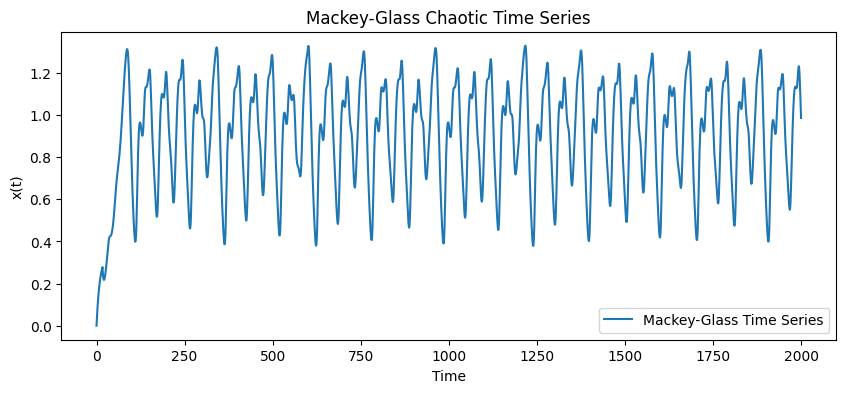

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series using the 4th-order Runge-Kutta method.
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    return x[delay_steps:]  # Return only the valid part of the time series

# Generate and plot the Mackey-Glass time series
time_series = mackey_glass(dt=1, T=2000)

plt.figure(figsize=(10, 4))
plt.plot(time_series, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

### Prepare trainig and testing data partitions

In [3]:
### Prepare the data
def create_io_pairs(data, window_size):
    """
    Create input-output pairs for training/testing.
    """
    inputs = []
    outputs = []
    for i in range(len(data) - window_size):
        inputs.append(data[i:i + window_size])
        outputs.append(data[i + window_size])
    return np.array(inputs), np.array(outputs)

### Data settings
window_size = 10  # Use the last 10 time steps to predict the next step
train_size = 1000  # Use the first 1000 points for training
test_size = 500   # Use the next 500 points for testing

### Create data
train_inputs, train_outputs = create_io_pairs(time_series[:train_size], window_size)
test_inputs, test_outputs = create_io_pairs(time_series[train_size:train_size + test_size], window_size)

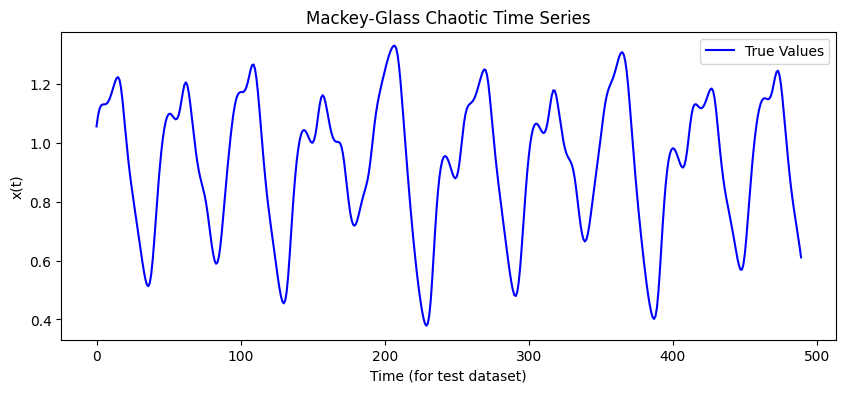

In [4]:
### Plot the test set
plt.figure(figsize=(10, 4))
plt.plot(test_outputs, label="True Values", color="blue")
plt.xlabel('Time (for test dataset)')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

## <font color="blue">Model development</font>

In [5]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

### Quantum reservoir hyper-parameters

In [6]:
n_qubits = 4  # Number of qubits in the reservoir
n_layers = 2  # Number of layers in the quantum circuit

### Quantum device to use
dev = qml.device("default.qubit", wires=n_qubits)

### Create and initialize the reservoir
*This includes its function and a circuit*

In [7]:
def quantum_reservoir(inputs, weights, biases, leakage_rate=0.1, previous_state=None):
    """
    Quantum reservoir with classical-inspired fading memory
    previous_state: Array of previous expectation values (Pauli X,Y,Z for all qubits)
    """
    n_observables = 3 * n_qubits  # X,Y,Z for each qubit
    
    ### Initialize previous state if first run
    if previous_state is None:
        previous_state = np.zeros(n_observables)
    
    ### Encode input with bias (scaled by leakage rate)
    for i in range(n_qubits):
        # Combined input transformation similar to classical case
        transformed_input = leakage_rate * (inputs[i % len(inputs)] + biases[i])
        qml.RX(transformed_input, wires=i)
    
    ### Entangling blocks with given/random weights
    #   Apply reservoir dynamics (weighted by leakage rate)
    for layer in range(n_layers):
        # Rotation block with rotations scaled by (1-leakage_rate)
        for i in range(n_qubits):
            scaled_weights = (1 - leakage_rate) * weights[layer, i]
            qml.Rot(*scaled_weights, wires=i)
        # Entangling block
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    
    ### Measure all Pauli observables
    observables = [qml.expval(qml.PauliX(i)) for i in range(n_qubits)] + \
                  [qml.expval(qml.PauliY(i)) for i in range(n_qubits)] + \
                  [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    return observables

In [8]:
# Quantum node to measure all Pauli observables
@qml.qnode(dev)
def reservoir_circuit(inputs, weights, biases, leakage_rate=0.1, previous_state=None):
    return quantum_reservoir(inputs, weights, biases, leakage_rate, previous_state)

### Train the reservoir
*Includes the readout layer.*

In [9]:
### Train the reservoir and compute the readout weights
#   Regularization parameter lambda_reg
#   Initial bias and weight terms can also be passed in
def train_reservoir(train_inputs, train_outputs, n_layers, n_qubits, 
                   biases=None, weights=None, lambda_reg=1e-6, leakage_rate=0.1):
    
    # Initialize parameters
    if biases is None:
        biases = np.random.rand(n_qubits)
    if weights is None:
        weights = np.random.rand(n_layers, n_qubits, 3)
    
    # Train with state memory
    reservoir_states = []
    previous_state = None
    
    # Collect reservoir states
    for input_seq in train_inputs:
        # Get new state with memory effect
        current_state = reservoir_circuit(
            input_seq, weights, biases, leakage_rate, previous_state
        )
        reservoir_states.append(current_state)
        previous_state = current_state  # Update memory
    
    # Stack reservoir states and outputs
    R = np.vstack(reservoir_states)
    Y = train_outputs.reshape(-1, 1)
    
    # Train readout weights using ridge regression
    W_out = Y.T @ R @ np.linalg.inv(R.T @ R + lambda_reg * np.eye(3 * n_qubits))
    
    return W_out, weights, biases

### Predict the output from inputs

In [10]:
def predict(test_inputs, weights, biases, W_out, leakage_rate=0.1):
    predictions = []
    previous_state = None
    
    for input_seq in test_inputs:
        current_state = reservoir_circuit(
            input_seq, weights, biases, leakage_rate, previous_state
        )
        y_pred = W_out @ current_state
        predictions.append(y_pred[0])
        previous_state = current_state
    
    return np.array(predictions)

### Testing

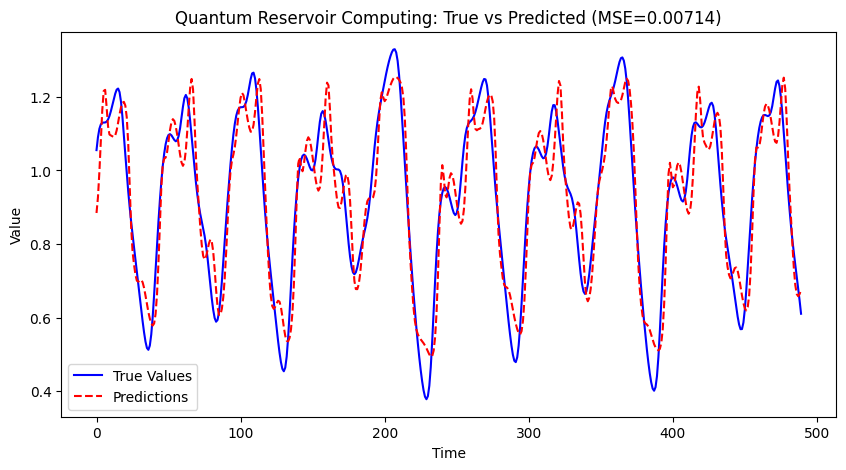

In [11]:
# Train the reservoir
W_out, weights, biases = train_reservoir(train_inputs, train_outputs, n_layers, n_qubits) #, biases)

# Test the reservoir
test_preds = predict(test_inputs, weights, biases, W_out)

# Evaluate reservoir performance
mse = np.mean((test_outputs - test_preds)**2)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(test_outputs, label="True Values", color="blue")
plt.plot(test_preds, label="Predictions", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f'Quantum Reservoir Computing: True vs Predicted (MSE={np.round(mse, 5)})')
plt.legend()
plt.show()

### Experimenting with leakage

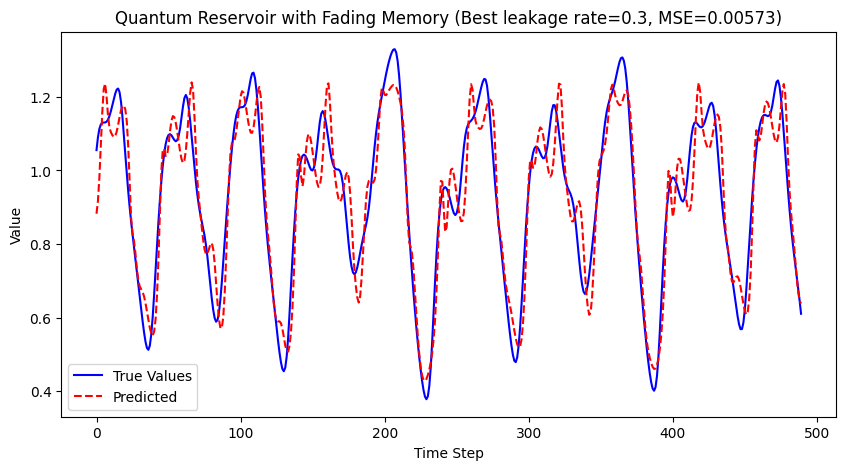

In [12]:
# Train with different leakage rates to find the optimum
leakage_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
best_mse = 10000
best_params = None

for rate in leakage_rates:
    W_out, weights, biases = train_reservoir(
        train_inputs, train_outputs, n_layers, n_qubits, leakage_rate=rate)
    test_preds = predict(test_inputs, weights, biases, W_out, leakage_rate=rate)
    current_mse = np.mean((test_outputs - test_preds)**2)
    current_params = (W_out, weights, biases, rate, current_mse)
    
    if current_mse < best_mse:
        best_mse = current_mse
        best_params = current_params

# Use best parameters for final prediction
W_out, weights, biases, best_rate, best_mse = best_params
plt.figure(figsize=(10, 5))
plt.plot(test_outputs, label="True Values", color="blue")
plt.plot(test_preds, label=f"Predicted", color="red", linestyle="--")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title(f'Quantum Reservoir with Fading Memory (Best leakage rate={best_rate}, MSE={np.round(best_mse, 5)})')
plt.legend()
plt.show()

## Write your observations here

- Task 1:
- Task 2:
- Task 3:
- Task 4:
- Task 5:
- Challenge:
- Reflection:

# Software in use (Linux)

In [13]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
torch                     2.6.0
torchaudio                2.6.0
torcheval                 0.0.7
torchmetrics              1.6.1
torchsummary              1.5.1
torchvision               0.21.0
